In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/LICENSE.txt
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_50.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_9.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_46.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_90.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_121.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_55.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_4.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_91.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_38.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_128.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_83.nii
/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/liver_116.nii
/kaggle/input/3d-liver-segmentation/Task03_Live

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.3 MB/s eta 0:00:00


# **Загрузка данных**

In [3]:
from glob import glob

#Создаем массивы images и labels, куда закидываем из путей все изображения с форматом .nii
images_nii = sorted(glob(f"/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr/*.nii"))
labels_nii = sorted(glob(f"/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr/*.nii"))

# **Обработка изображений *.nii и их визуализация**

In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def get_transpose(image,label,x=0,y=1,z=2):
    return image.transpose(x,y,z), label.transpose(x,y,z)

def get_slices_nii(images,labels,n=None):
    images_slices = list()
    labels_slices = list()
    
    if not n or n > len(images):
        n = len(images)
    
    
    for i, (im_nii, l_nii) in enumerate(zip(images, labels)):
        if i < n:
            image_nii = nib.load(im_nii).get_fdata()
            label_nii = nib.load(l_nii).get_fdata()

            image_nii,label_nii  = get_transpose(image_nii,label_nii,2,1,0)

            # ранее был использован enumerate
            for im, l in zip(image_nii, label_nii):
                if len(np.unique(l)) == 2:
                    images_slices.append(im.astype('float32'))
                    labels_slices.append(l.astype('float32'))
    
    return images_slices, labels_slices
    
def preprocessing_nii(images):
    for i in range(len(images)):
        images[i][images[i] < 0] = 0
        images[i] = images[i]/np.max(images[i])
        
    # Можно добавить и для labels, но так как изначально мы выбираем только те метки где есть только два класса для каждого пикселя, то можно не делать этого
#     for i in range(len(labels)):
#         labels[i][labels[i] > 1] = 1
    
    return images
                
def get_visualization(image,label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].imshow((image * 255).astype('uint8') * 255, cmap='gray')
    axes[0].set_title('Изображение')
    axes[0].axis('off')

    axes[1].imshow(label, cmap='gray')
    axes[1].set_title('Маска')
    axes[1].axis('off')


In [5]:
ims, ls = get_slices_nii(images_nii,labels_nii,123) 
ims = preprocessing_nii(ims)

Посмотрим на минимальные и максимальные значения в изображениях и их меток

In [6]:
print('Image')
print(f'Min value: {np.min(ims[0])}; Max value: {np.max(ims[0])}')
print()
print('Label')
print(f'Min value: {np.min(ls[0])}; Max value: {np.max(ls[0])}')

Image
Min value: 0.0; Max value: 1.0

Label
Min value: 0.0; Max value: 1.0


In [7]:
# import random

# Перешивает данные, чтобы можно было увидеть разные варианты изображений и их меток
# def shuffle_slices(images,labels):    
#     combined = list(zip(images,labels))

#     random.shuffle(combined)

#     images_shuffled, labels_shuffled = zip(*combined)

#     return images_shuffled, labels_shuffled

Функция выше закомментрирована, чтобы мы в дальнейшем смогли сравнить первые 10 изображений до обработки с помощью аугментаций и после нее

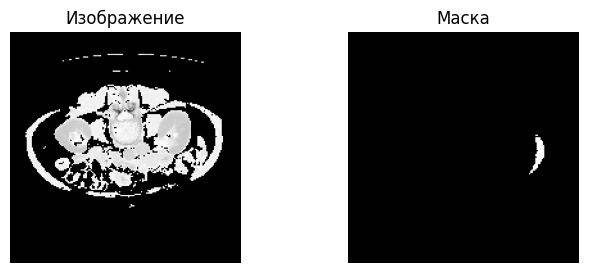

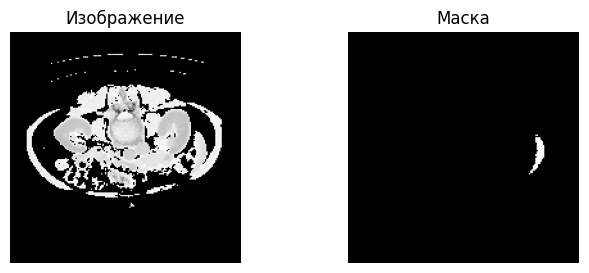

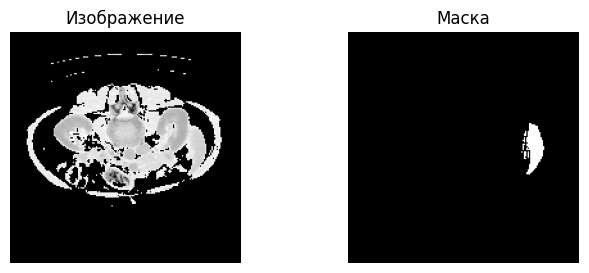

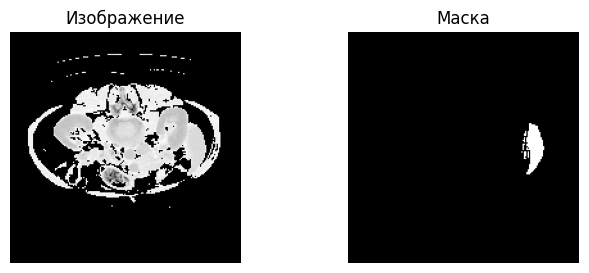

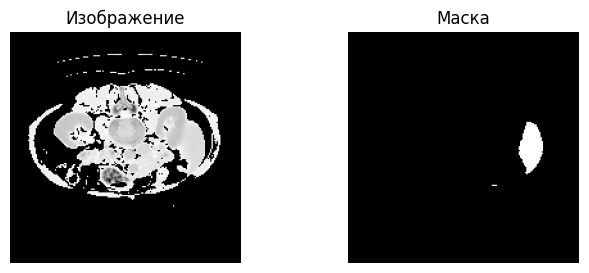

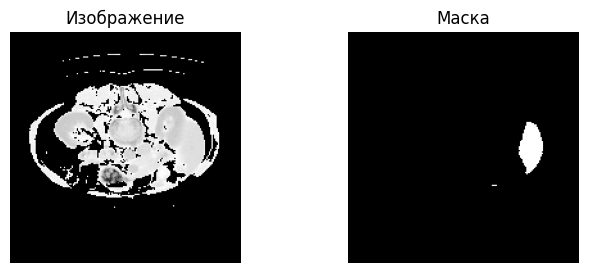

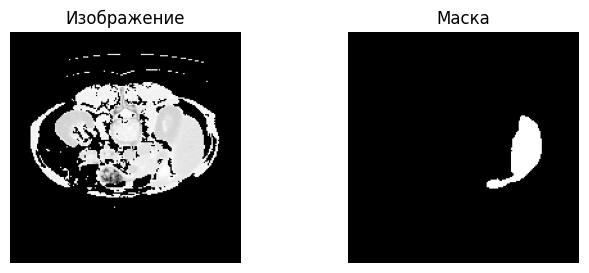

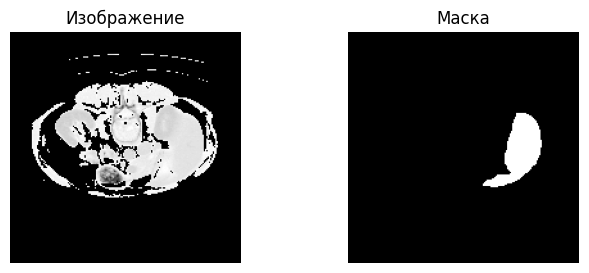

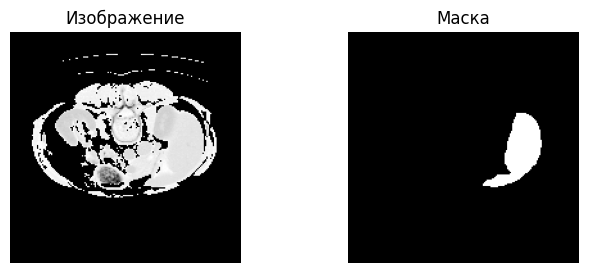

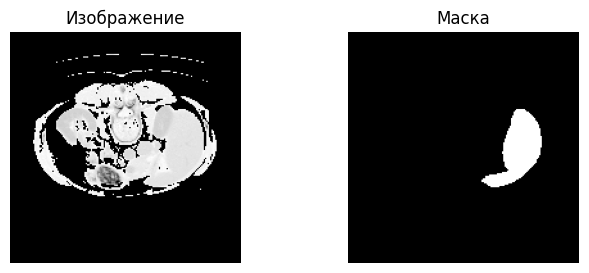

In [8]:
# ims_shuffle, ls_shuffle = shuffle_slices(ims,ls)
for i ,(im,l) in enumerate(zip(ims,ls)):
    if i < 10:
        get_visualization(im,l)

# **Обработка с помощью аугментации**

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def preprocessing_data(images, labels):
    # Определение аугментаций для изображений и масок
    data_transforms = A.Compose([
        A.Resize(256, 256),  # Изменение размера до 256x256 пикселей
        A.HorizontalFlip(),  # Горизонтальное отражение
        A.VerticalFlip(),    # Вертикальное отражение
        A.Rotate(limit=30),  # Поворот на случайный угол до ±30 градусов
        ToTensorV2()  # Преобразование в тензор PyTorch
    ])

    # Применение аугментаций к изображению
    
    images_transfromed = list()
    labels_transformed = list()
    
    for im,l in zip(images,labels):
        data_transformed = data_transforms(image=im,mask=l)
        
        im_transformed = data_transformed['image']
        l_transformed = data_transformed['mask']
        
        im_transformed = im_transformed.float()
        l_transformed = l_transformed.unsqueeze(0).float()
        
        images_transfromed.append(im_transformed)
        labels_transformed.append(l_transformed)
        
    
    return images_transfromed, labels_transformed

In [10]:
ims_transformed, ls_transformed =  preprocessing_data(ims,ls)

In [11]:
ims_transformed[0].shape

torch.Size([1, 256, 256])

In [12]:
# Визуализация тензоров изображений и их меток
def get_visualization_tensor(image,label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].imshow((image * 255).squeeze(0).numpy().astype('uint8') * 255, cmap='gray')
    axes[0].set_title('Изображение')
#     axes[0].axis('off')

    axes[1].imshow(label.squeeze(0), cmap='gray')
    axes[1].set_title('Маска')
#     axes[1].axis('off')

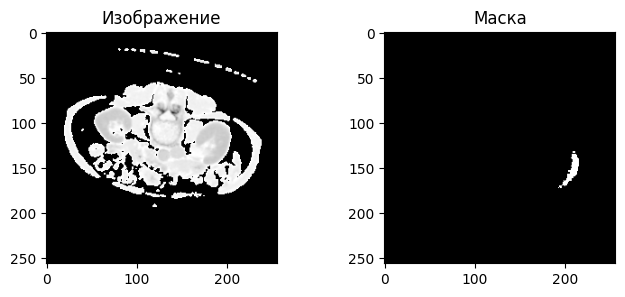

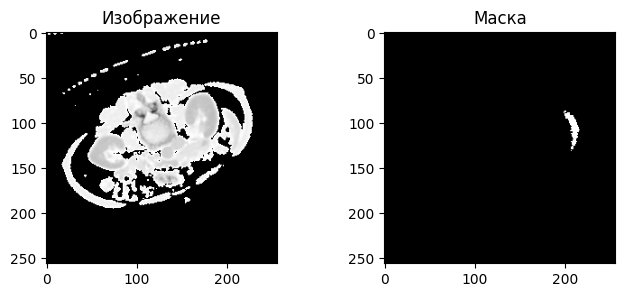

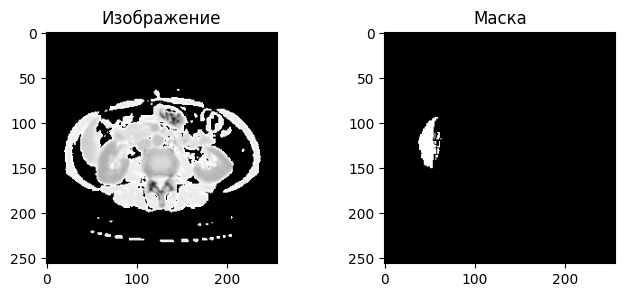

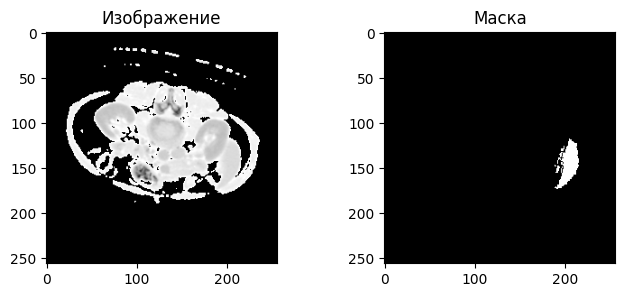

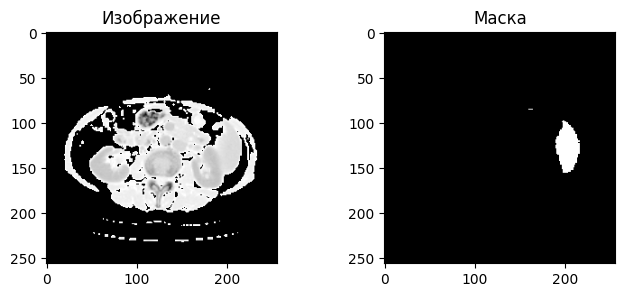

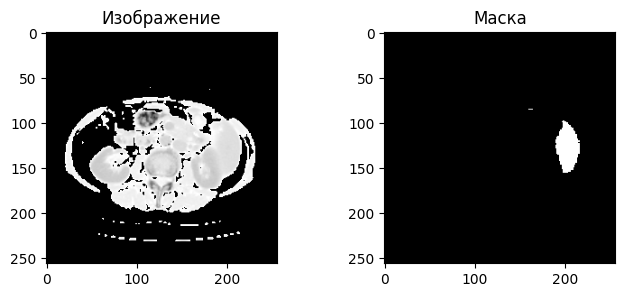

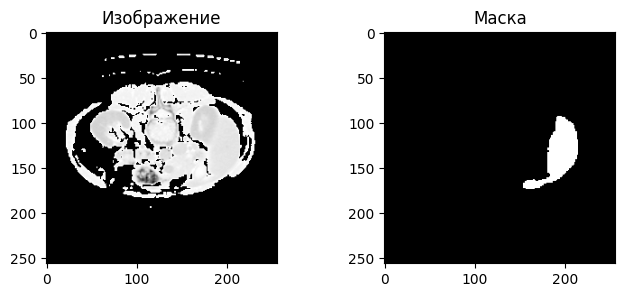

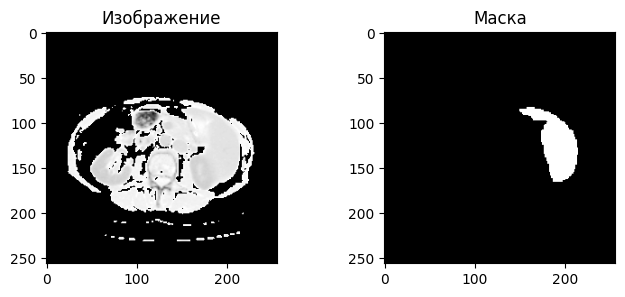

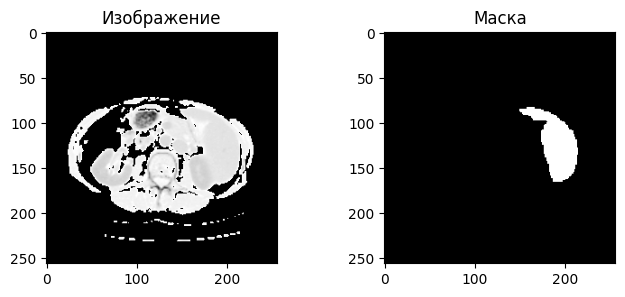

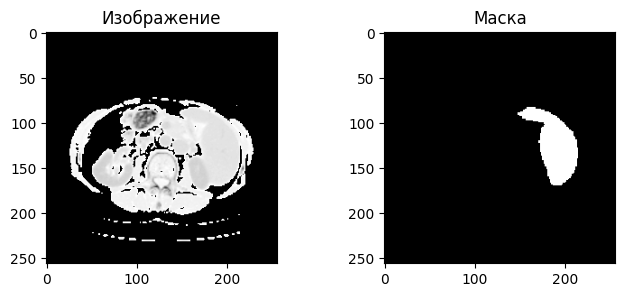

In [13]:
for i ,(im,l) in enumerate(zip(ims_transformed,ls_transformed)):
    if i < 10:
        get_visualization_tensor(im,l)

# **Преобразование данных в датасет**

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Используем Dataset для создания пользовательского датасета CustomDataset, далее обернем его в DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


custom_dataset = CustomDataset(ims_transformed, ls_transformed)


train_size = int(0.6 * len(custom_dataset))
val_size = int(0.2 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(custom_dataset, [train_size,val_size,test_size])

batch_size = 8

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

In [15]:
print(f'Train(тренировочный) объём данных: {len(train_loader)}')
print(f'Val(валидационный) объём данных: {len(val_loader)}')
print(f'Test(тестовый) объём данных: {len(test_loader)}')

Train(тренировочный) объём данных: 318
Val(валидационный) объём данных: 106
Test(тестовый) объём данных: 106


# **Индекс Жакара**

In [16]:
# def get_iou(outputs, labels):
#     outputs = torch.sigmoid(outputs) > 0.5
#     outputs = outputs.squeeze(1).byte()
#     labels = labels.squeeze(1).byte()
#     eps = 1e-8
#     intersection = (outputs & labels).float().sum((1, 2))
#     union = (outputs | labels).float().sum((1, 2))
    
#     iou = (intersection + eps) / (union + eps)

#     return torch.mean(iou).item()


def get_iou(out,labels):
    eps = 1e-8
    out = torch.sigmoid(out) > 0.9
    out = out.squeeze(1)
    labels = labels.squeeze(1)
    intersection = torch.logical_and(out, labels).sum().float()
    union = torch.logical_or(out, labels).sum().float()
    
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

# **Тренировка**

In [17]:
if torch.cuda.is_available():
    print('CUDA доступен. Вычисления будут производиться на GPU.')
else:
    print('CUDA недоступен. Вычисления будут производиться на CPU.')

CUDA доступен. Вычисления будут производиться на GPU.


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Ипользуем коллбэки для сохранения моделей

In [19]:
import torch

class BestModelCheckpointCallback:
    def __init__(self, model, filepath, monitor='iou_val', mode='min'):
        self.model = model
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_metric = float('inf') if mode == 'min' else float('-inf')

    def __call__(self, metric, name_model):
        if (self.mode == 'min' and metric < self.best_metric) or (self.mode == 'max' and metric > self.best_metric):
            self.best_metric = metric
            torch.save(self.model.state_dict(), self.filepath.format(name_model))
            print(f"Model saved with {self.monitor}: {metric}")

# Определение пути для сохранения наилучшей модели
filepath = 'best_model_{}.pth'

In [20]:
def train(model,train_dl,val_dl,num_epochs, loss_fn, optimizer, name_model, use_scheduler=False, access_key=True):    
    model = model.to(device)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[num_epochs//2, num_epochs//1.4, num_epochs//1.2], gamma=0.2)
    
    history = {'epochs loss train':[],'epochs loss val':[],'iou(Jaccard index) train':[],'iou(Jaccard index) val':[]}
    
    best_model_callback = BestModelCheckpointCallback(model, filepath, monitor='iou_val', mode='max')
    
    for epoch in range(num_epochs):
        epoch_loss_train = 0
        epoch_loss_val = 0
        iou_batches_val = []
        iou_batches_train = []
              
        model.train()
        for batch in train_dl:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            if access_key:
                output = model(images)['out']
            else:
                output = model(images)

            loss_train = loss_fn(output, labels)
            loss_train.backward()
            
            optimizer.step()
            
            epoch_loss_train += loss_train.item()
            
            iou = get_iou(output,labels)
            iou_batches_train.append(iou)
        
        avg_iou_epoch_train = sum(iou_batches_train)/len(iou_batches_train)
        
        if use_scheduler:
            scheduler.step()
        
        model.eval()
                 
        for batch in val_dl:  
            images, labels = batch
            images, labels = images.to(device), labels
            
            with torch.no_grad():
                if access_key:
                    out = model(images)['out'].detach().cpu()
                else:
                    out = model(images).detach().cpu()
                
                loss_val = loss_fn(out, labels)
                epoch_loss_val += loss_val.item()
            
            iou = get_iou(out,labels)
            
            iou_batches_val.append(iou)
        
        avg_iou_epoch_val = sum(iou_batches_val)/len(iou_batches_val)
        
        best_model_callback(avg_iou_epoch_val, name_model)
        
        history['epochs loss train'].append(epoch_loss_train/len(train_dl))
        history['epochs loss val'].append(epoch_loss_val/len(val_dl))
        history['iou(Jaccard index) train'].append(avg_iou_epoch_train)
        history['iou(Jaccard index) val'].append(avg_iou_epoch_val)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('------------')
        print(f'Loss train: {epoch_loss_train/len(train_dl):.4f}')
        print(f'Loss val: {epoch_loss_val/len(val_dl):.4f}')
        print(f'Iou(Jaccard index) train: {avg_iou_epoch_train:.4f}')
        print(f'Iou(Jaccard index) val: {avg_iou_epoch_val:.4f}')
        print('------------')
        
    return history

# **Модель на основе архитектуры U-Net (собственная реализация)**

In [21]:
import torch.nn as nn

moment = 0.1

# Определение блока свертки для пути умешьшения размерности (Convolution Block)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels, momentum= moment),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)
    
# Определение блока свертки для пути увеличения размерности (Convolution Block Up) 
class ConvBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlockUp, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels//2, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels//2, momentum= moment),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

# Определение U-Net модели
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.enc0 = ConvBlock(in_channels,64)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        
        self.enc1 = ConvBlock(64,128)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2 = ConvBlock(128,256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3 = ConvBlock(256,512)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3,stride=1, padding = 1),  
            nn.BatchNorm2d(1024, momentum= moment),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(512, momentum= moment),
            nn.ReLU()
        ) 
        
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec0 = ConvBlockUp(1024,512)
        
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec1 = ConvBlockUp(512,256)
        
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec2 = ConvBlockUp(256,128)
        
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(64, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(64, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1,stride=1)
        )

    def forward(self, x):
        
        enc0 = self.enc0(x)
        maxpool0 = self.maxpool0(enc0)
        
        enc1 = self.enc1(maxpool0)
        maxpool1 = self.maxpool1(enc1)
        
        enc2 = self.enc2(maxpool1)
        maxpool2 = self.maxpool2(enc2)
               
        enc3 = self.enc3(maxpool2)
        maxpool3 = self.maxpool3(enc3)
        
        bottleneck = self.bottleneck(maxpool3)
        
        dec0 = self.upsample0(bottleneck)
        dec0 = self.dec0(torch.cat((dec0,enc3), dim =1))
        
        dec1 = self.upsample1(dec0)
        dec1 = self.dec1(torch.cat((dec1,enc2), dim =1))
        
        dec2 = self.upsample2(dec1)
        dec2 = self.dec2(torch.cat((dec2,enc1), dim =1))
        
        dec3 = self.upsample3(dec2)
        dec3 = self.dec3(torch.cat((dec3,enc0), dim =1))
        
        return {'out': dec3}

In [22]:
import torch.optim as optim

# Определение модели
model_unet = UNet(in_channels=1, out_channels=1)

# Определение функции потерь и оптимизатора
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.001)

# Обучение модели
history_unet = train(model = model_unet,train_dl=train_loader,val_dl=val_loader,num_epochs=30,loss_fn=loss_fn,optimizer=optimizer, name_model='U-Net', use_scheduler=True)

Model saved with iou_val: 0.34921075825421866
Epoch 1/30
------------
Loss train: 0.1129
Loss val: 0.0479
Iou(Jaccard index) train: 0.3431
Iou(Jaccard index) val: 0.3492
------------
Model saved with iou_val: 0.3665356933367702
Epoch 2/30
------------
Loss train: 0.0483
Loss val: 0.0425
Iou(Jaccard index) train: 0.5021
Iou(Jaccard index) val: 0.3665
------------
Model saved with iou_val: 0.5982940944860566
Epoch 3/30
------------
Loss train: 0.0379
Loss val: 0.0339
Iou(Jaccard index) train: 0.5840
Iou(Jaccard index) val: 0.5983
------------
Epoch 4/30
------------
Loss train: 0.0339
Loss val: 0.0954
Iou(Jaccard index) train: 0.6474
Iou(Jaccard index) val: 0.0385
------------
Model saved with iou_val: 0.6261745249887682
Epoch 5/30
------------
Loss train: 0.0352
Loss val: 0.0286
Iou(Jaccard index) train: 0.6199
Iou(Jaccard index) val: 0.6262
------------
Model saved with iou_val: 0.7920348447448803
Epoch 6/30
------------
Loss train: 0.0295
Loss val: 0.0283
Iou(Jaccard index) train: 0.6

# **Модель на основе архитектуры DeepLabV3**

In [23]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.optim as optim

# Определение модели
model_deeplabv3 = deeplabv3_resnet50(num_classes=1)

# Изменение количества входных каналов на 1
model_deeplabv3.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)

# # Изменение количества выходных каналов на 1
# model_deeplabv3.classifier[-1] = torch.nn.Conv2d(256, 1, kernel_size=1, stride=1)

# Определение функции потерь и оптимизатора
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_deeplabv3.parameters(), lr=0.001)

# Обучение модели
history_deeplabv3 = train(model = model_deeplabv3,train_dl=train_loader,val_dl=val_loader,num_epochs=30,loss_fn=loss_fn,
                          optimizer=optimizer,name_model='DeepLabV3',use_scheduler=True, access_key=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


Model saved with iou_val: 0.33062555391411735
Epoch 1/30
------------
Loss train: 0.0903
Loss val: 0.0513
Iou(Jaccard index) train: 0.3911
Iou(Jaccard index) val: 0.3306
------------
Epoch 2/30
------------
Loss train: 0.0369
Loss val: 0.0564
Iou(Jaccard index) train: 0.6047
Iou(Jaccard index) val: 0.0892
------------
Model saved with iou_val: 0.7389965912081161
Epoch 3/30
------------
Loss train: 0.0284
Loss val: 0.0247
Iou(Jaccard index) train: 0.7035
Iou(Jaccard index) val: 0.7390
------------
Epoch 4/30
------------
Loss train: 0.0298
Loss val: 0.0249
Iou(Jaccard index) train: 0.6788
Iou(Jaccard index) val: 0.7095
------------
Model saved with iou_val: 0.7627013679945244
Epoch 5/30
------------
Loss train: 0.0247
Loss val: 0.0254
Iou(Jaccard index) train: 0.7387
Iou(Jaccard index) val: 0.7627
------------
Model saved with iou_val: 0.7699128484950876
Epoch 6/30
------------
Loss train: 0.0230
Loss val: 0.0213
Iou(Jaccard index) train: 0.7542
Iou(Jaccard index) val: 0.7699
----------

# **Модель на основе архитектуры Unet от MONAI**

In [24]:
from monai.networks.nets import Unet

2024-05-30 15:54:27.894294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 15:54:27.894393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 15:54:28.019068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
model_unet_monai = Unet(spatial_dims=2,in_channels=1,out_channels=1,channels=(64, 128, 256, 512, 1024),strides=(2,2,2,2))

# Определение функции потерь и оптимизатора
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_unet_monai.parameters(), lr=0.001)

# Обучение модели
history_unet_monai = train(model = model_unet_monai,train_dl=train_loader,val_dl=val_loader,num_epochs=30,loss_fn=loss_fn,optimizer=optimizer,name_model='U-Net_monai',use_scheduler=True,access_key=False)

Model saved with iou_val: 0.18223842879194976
Epoch 1/30
------------
Loss train: 0.0990
Loss val: 0.0555
Iou(Jaccard index) train: 0.2362
Iou(Jaccard index) val: 0.1822
------------
Model saved with iou_val: 0.567351261399827
Epoch 2/30
------------
Loss train: 0.0495
Loss val: 0.0394
Iou(Jaccard index) train: 0.4504
Iou(Jaccard index) val: 0.5674
------------
Model saved with iou_val: 0.6938294692421859
Epoch 3/30
------------
Loss train: 0.0402
Loss val: 0.0367
Iou(Jaccard index) train: 0.5499
Iou(Jaccard index) val: 0.6938
------------
Epoch 4/30
------------
Loss train: 0.0347
Loss val: 0.0320
Iou(Jaccard index) train: 0.6083
Iou(Jaccard index) val: 0.6407
------------
Epoch 5/30
------------
Loss train: 0.0314
Loss val: 0.0281
Iou(Jaccard index) train: 0.6494
Iou(Jaccard index) val: 0.6828
------------
Epoch 6/30
------------
Loss train: 0.0283
Loss val: 0.0297
Iou(Jaccard index) train: 0.6851
Iou(Jaccard index) val: 0.5490
------------
Epoch 7/30
------------
Loss train: 0.0250


# **Сравнение моделей**

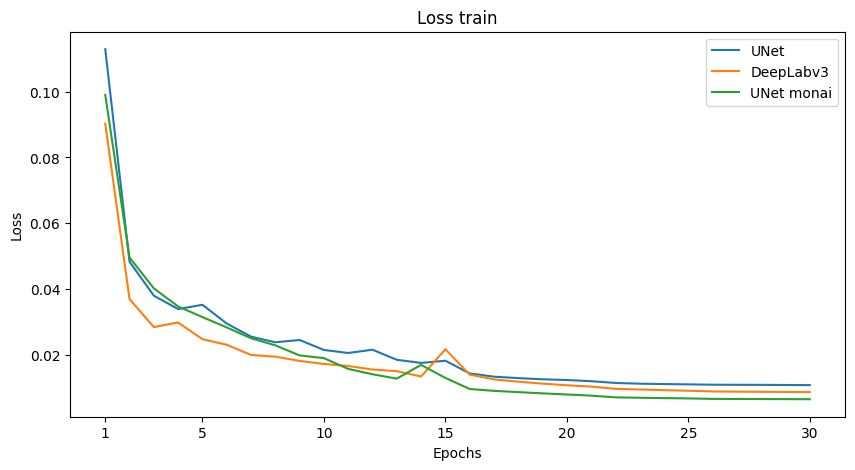

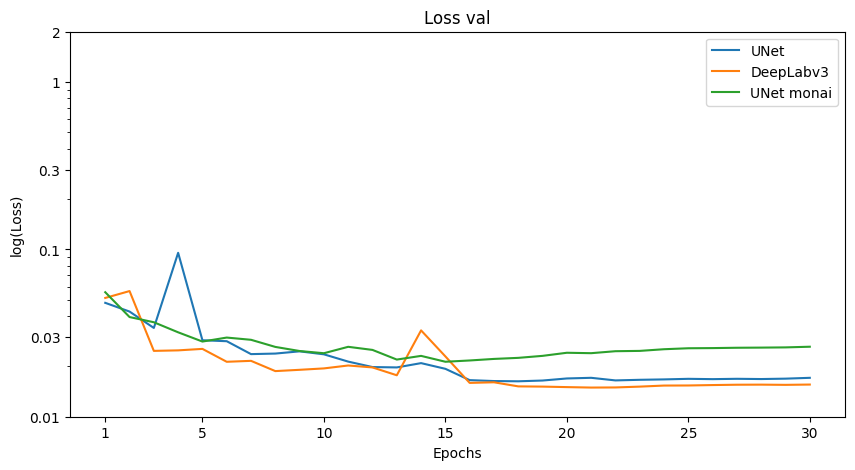

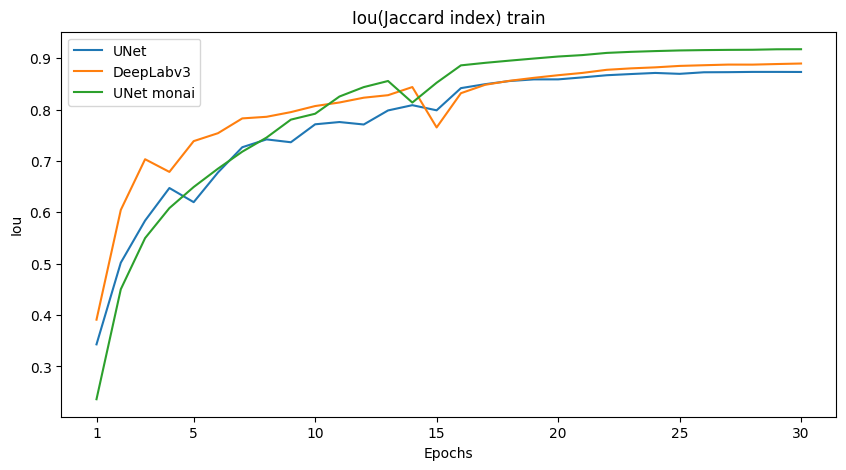

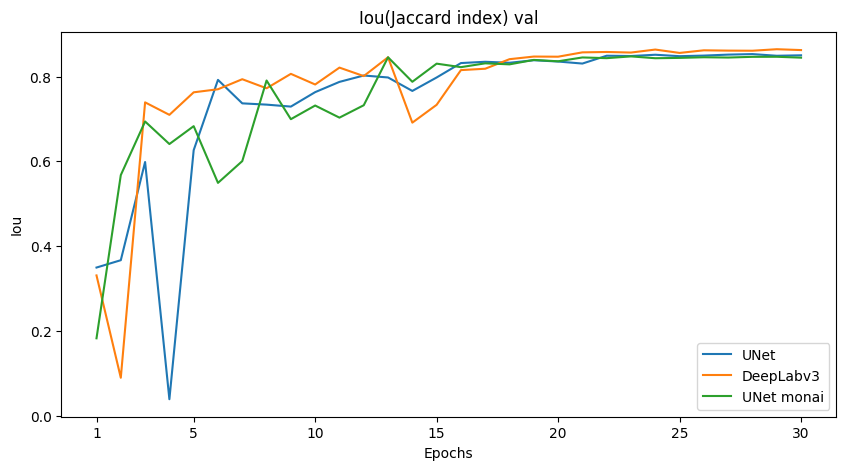

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['epochs loss train'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['epochs loss train'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['epochs loss train'], label='UNet monai')
plt.title('Loss train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['epochs loss val'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['epochs loss val'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['epochs loss val'], label='UNet monai')
plt.title('Loss val')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.yscale('log')
plt.yticks([0.01,0.03,0.1,0.3,1,2],[0.01,0.03,0.1,0.3,1,2])
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['iou(Jaccard index) train'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['iou(Jaccard index) train'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['iou(Jaccard index) train'], label='UNet monai')
plt.title('Iou(Jaccard index) train')
plt.xlabel('Epochs')
plt.ylabel('Iou')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['iou(Jaccard index) val'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['iou(Jaccard index) val'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['iou(Jaccard index) val'], label='UNet monai')
plt.title('Iou(Jaccard index) val')
plt.xlabel('Epochs')
plt.ylabel('Iou')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.legend()

In [27]:
model_unet.load_state_dict(torch.load('/kaggle/working/best_model_U-Net.pth'))
model_deeplabv3.load_state_dict(torch.load('/kaggle/working/best_model_DeepLabV3.pth'))
model_unet_monai.load_state_dict(torch.load('/kaggle/working/best_model_U-Net_monai.pth'))

<All keys matched successfully>

In [28]:
model_unet.eval()
model_deeplabv3.eval()
model_unet_monai.eval()

iou_test_unet = []
iou_test_deeplabv3 = []
iou_test_unet_monai = []

for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
    
    with torch.no_grad():
        out_unet = model_unet(images)['out'].detach().cpu()
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu() 
        out_unet_monai = model_unet_monai(images).detach().cpu()
    
    iou_unet = get_iou(out_unet,labels)
    iou_deeplabv3 = get_iou(out_deeplabv3,labels)
    iou_unet_monai = get_iou(out_unet_monai,labels)
            
    iou_test_unet.append(iou_unet)
    iou_test_deeplabv3.append(iou_deeplabv3)
    iou_test_unet_monai.append(iou_unet_monai)

print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для U-Net модели на тестовых данных: {sum(iou_test_unet)/len(iou_test_unet):.4f}')
print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для DeeplabV3 модели на тестовых данных: {sum(iou_test_deeplabv3)/len(iou_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для U-Net модели от Monai на тестовых данных: {sum(iou_test_unet_monai)/len(iou_test_unet_monai):.4f}')
print('---------------------------------------------------------')

---------------------------------------------------------
Iou(Индекс Жакара) для U-Net модели на тестовых данных: 0.8417
---------------------------------------------------------
Iou(Индекс Жакара) для DeeplabV3 модели на тестовых данных: 0.8549
---------------------------------------------------------
Iou(Индекс Жакара) для U-Net модели от Monai на тестовых данных: 0.8357
---------------------------------------------------------


In [29]:
for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
            
    with torch.no_grad():
        out_unet = model_unet(images)['out'].detach().cpu()
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu()
        out_unet_monai = model_unet_monai(images).detach().cpu()
        
    break

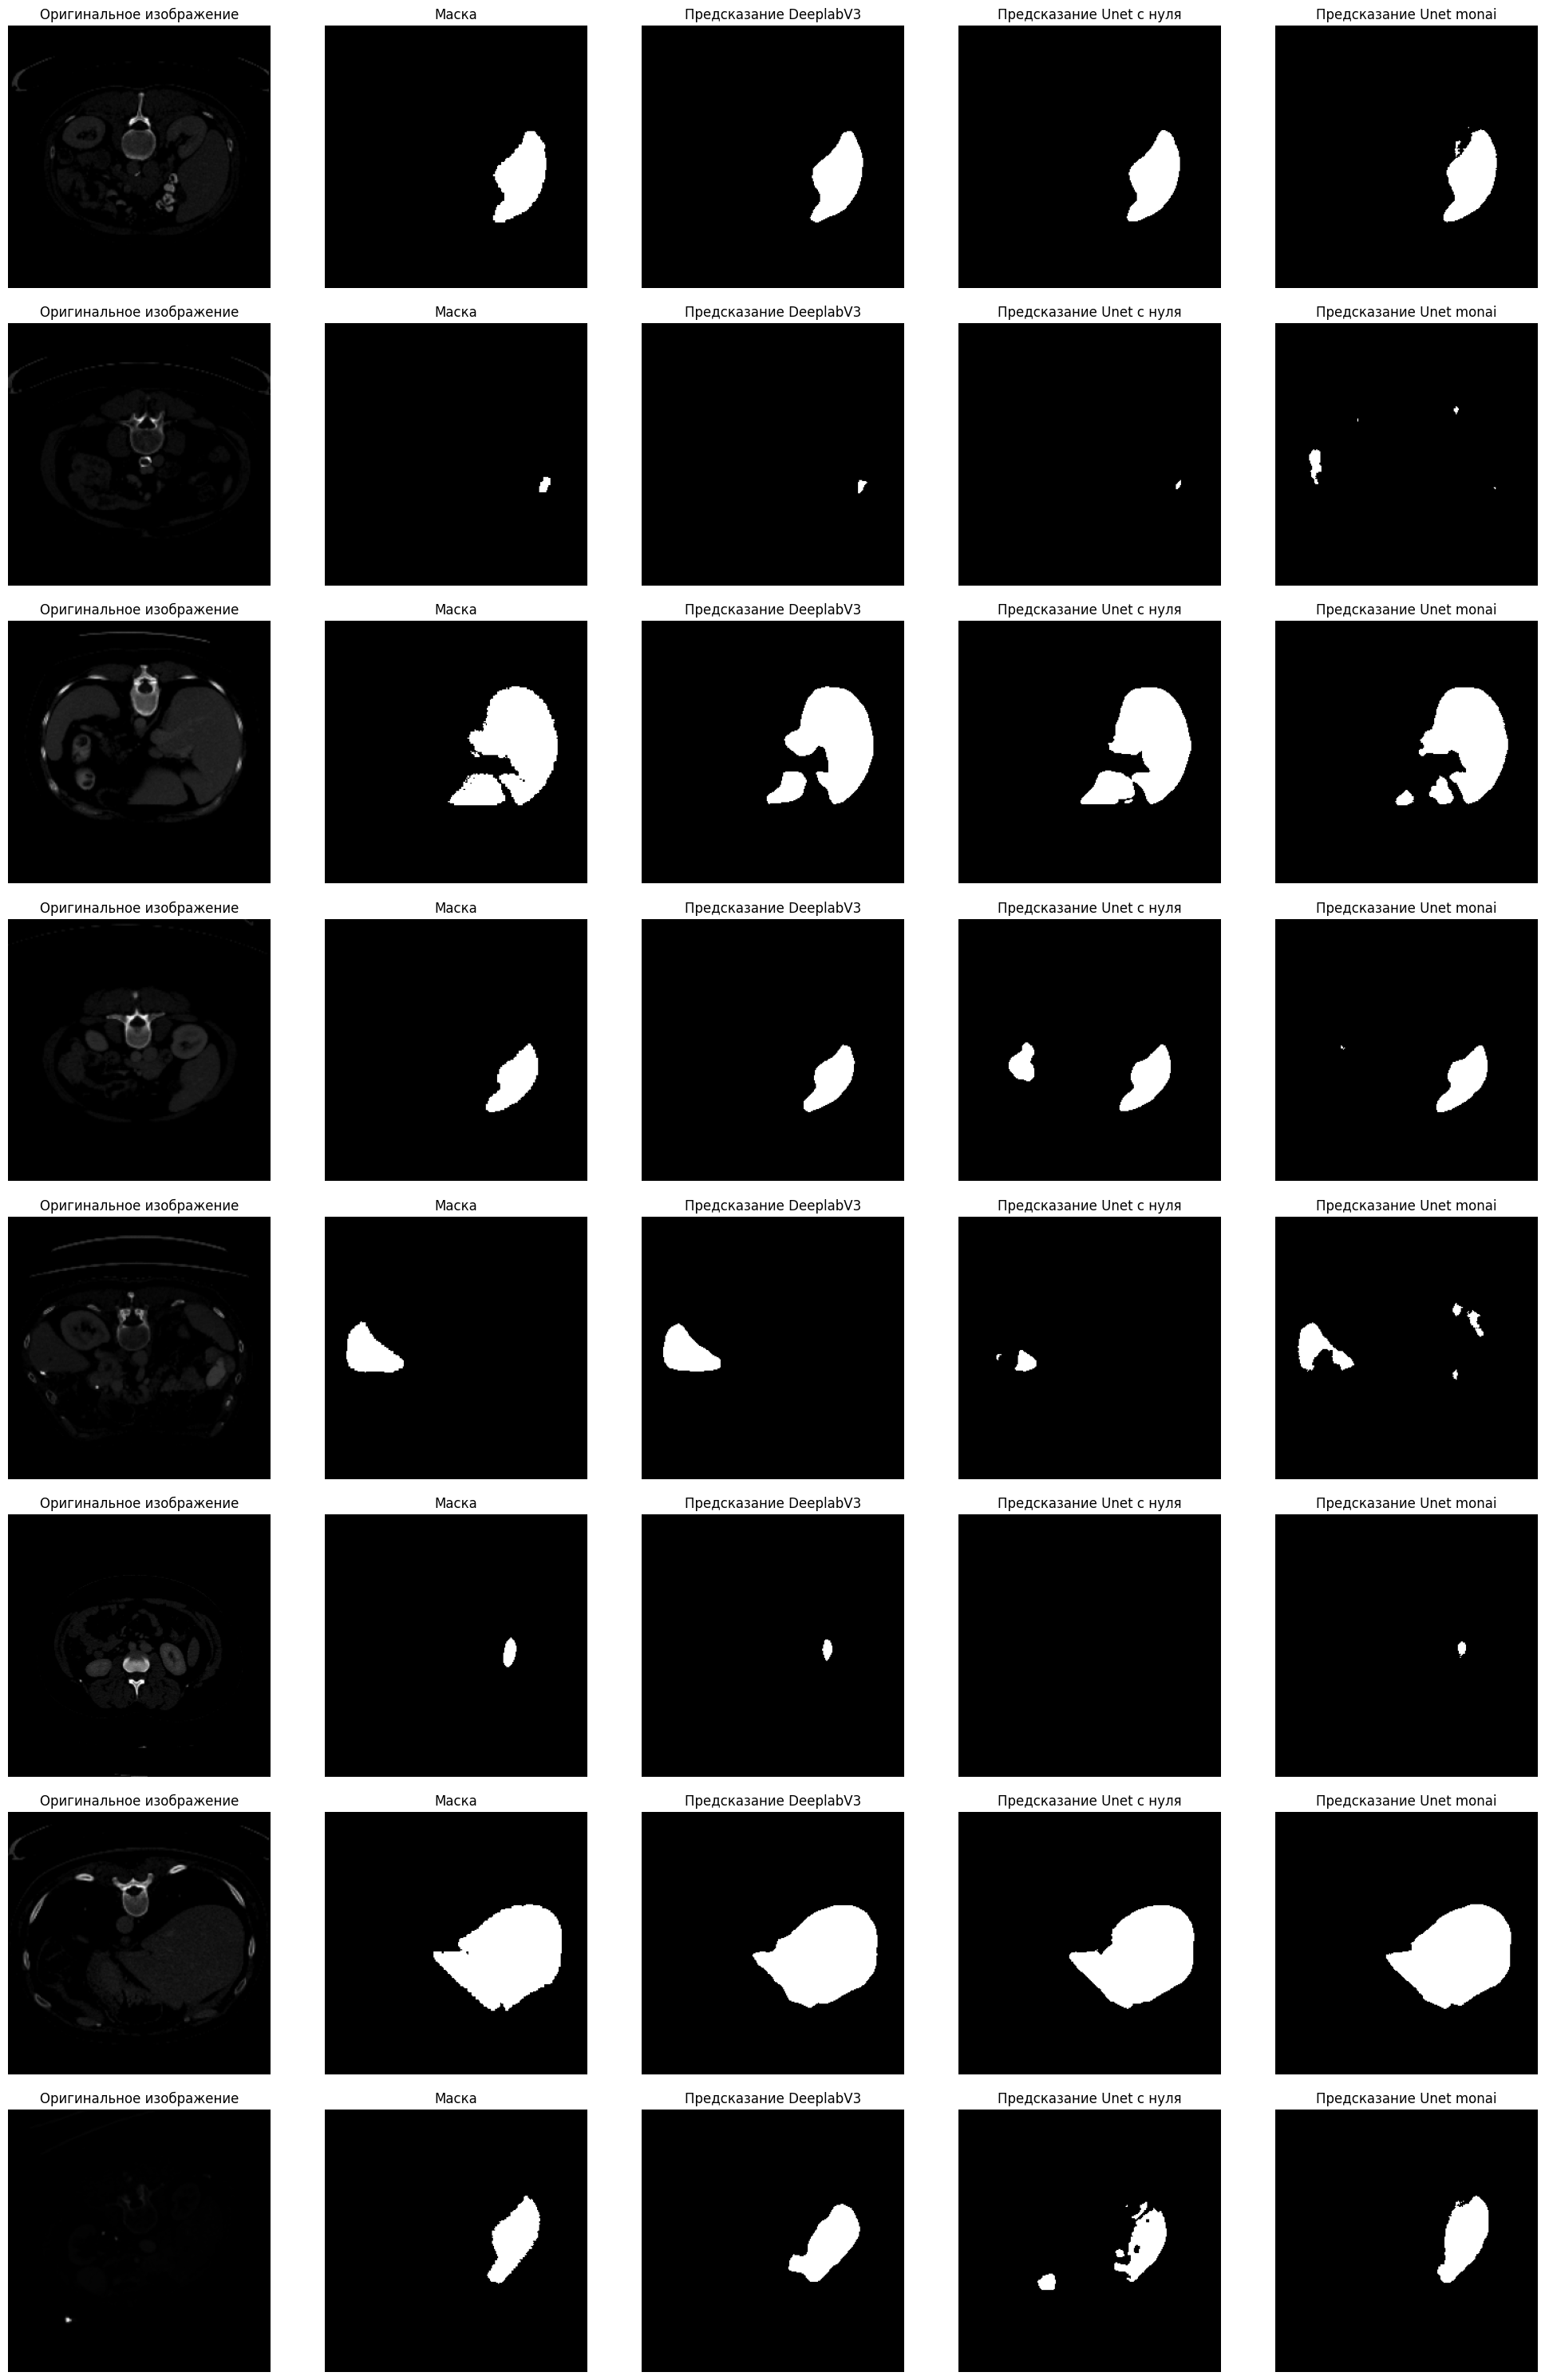

In [30]:
images = images.cpu()

fig,axes = plt.subplots(8,5,figsize=(20,30))
fig.tight_layout()
for i in range(len(axes)):
    if i<8:
        axes[i][0].imshow(images[i].squeeze(0), cmap='gray')
        axes[i][0].set_title('Оригинальное изображение')
        axes[i][0].axis('off')

        axes[i][1].imshow(labels[i].squeeze(0), cmap='gray')
        axes[i][1].set_title('Маска')
        axes[i][1].axis('off')

        axes[i][2].imshow(torch.sigmoid(out_deeplabv3[i].squeeze(0)) > 0.7, cmap='gray')
        axes[i][2].set_title('Предсказание DeeplabV3')
        axes[i][2].axis('off')

        axes[i][3].imshow(torch.sigmoid(out_unet[i].squeeze(0)) > 0.7, cmap='gray')
        axes[i][3].set_title('Предсказание Unet с нуля')
        axes[i][3].axis('off')
        
        axes[i][4].imshow(torch.sigmoid(out_unet_monai[i].squeeze(0)) > 0.7, cmap='gray')
        axes[i][4].set_title('Предсказание Unet monai')
        axes[i][4].axis('off')

# **Recall,Precision,F1 score**

In [31]:
def get_recall(out,labels):
    out = torch.sigmoid(out) > 0.9
    out = out.squeeze(1)
    labels = labels.squeeze(1)
    
    tp = torch.logical_and(out,labels).sum().float()
    fn = torch.logical_and(~out, labels).sum().float()
    
    recall = tp/(tp+fn)
    
    return recall.mean().item()

def get_precision(out,labels):
    out = torch.sigmoid(out) > 0.9
    out = out.squeeze(1)
    labels = labels.squeeze(1)
    
    tp = torch.logical_and(out,labels).sum().float()
    fp = torch.logical_and(out, ~(labels.int())).sum().float()
    
    precision = tp/(tp+fp)
    
    return precision.mean().item()

def get_f1_score(out,labels):
    
    recall = get_recall(out,labels)
    precision = get_precision(out,labels)
    
    f1_score = 2*precision*recall/(precision+recall)
    
    return f1_score

In [32]:
model_unet.eval()
model_deeplabv3.eval()
model_unet_monai.eval()

recall_test_unet = []
recall_test_deeplabv3 = []
recall_test_unet_monai = []

precision_test_unet = []
precision_test_deeplabv3 = []
precision_test_unet_monai = []

f1_score_test_unet = []
f1_score_test_deeplabv3 = []
f1_score_test_unet_monai = []

for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
    
    with torch.no_grad():
        out_unet = model_unet(images)['out'].detach().cpu()
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu() 
        out_unet_monai = model_unet_monai(images).detach().cpu()
    
    recall_unet = get_recall(out_unet,labels)
    recall_deeplabv3 = get_recall(out_deeplabv3,labels)
    recall_unet_monai = get_recall(out_unet_monai,labels)
    
    precision_unet = get_precision(out_unet,labels)
    precision_deeplabv3 = get_precision(out_deeplabv3,labels)
    precision_unet_monai = get_precision(out_unet_monai,labels)
    
    f1_score_unet = get_f1_score(out_unet,labels)
    f1_score_deeplabv3 = get_f1_score(out_deeplabv3,labels)
    f1_score_unet_monai = get_f1_score(out_unet_monai,labels)
            
    recall_test_unet.append(recall_unet)
    recall_test_deeplabv3.append(recall_deeplabv3)
    recall_test_unet_monai.append(recall_unet_monai)

    precision_test_unet.append(precision_unet)
    precision_test_deeplabv3.append(precision_deeplabv3)
    precision_test_unet_monai.append(precision_unet_monai)

    f1_score_test_unet.append(f1_score_unet)
    f1_score_test_deeplabv3.append(f1_score_deeplabv3)
    f1_score_test_unet_monai.append(f1_score_unet_monai)

print('---------------------------------------------------------')
print(f'Recall для U-Net модели на тестовых данных: {sum(recall_test_unet)/len(recall_test_unet)}')
print('---------------------------------------------------------')
print(f'Recall для DeeplabV3 модели на тестовых данных: {sum(recall_test_deeplabv3)/len(recall_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'Recall для U-Net модели от Monai на тестовых данных: {sum(recall_test_unet_monai)/len(recall_test_unet_monai):.4f}')
print('---------------------------------------------------------')

print('---------------------------------------------------------')
print(f'Precision для U-Net модели на тестовых данных: {sum(precision_test_unet)/len(precision_test_unet):.4f}')
print('---------------------------------------------------------')
print(f'Precision для DeeplabV3 модели на тестовых данных: {sum(precision_test_deeplabv3)/len(precision_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'Precision для U-Net модели от Monai на тестовых данных: {sum(precision_test_unet_monai)/len(precision_test_unet_monai):.4f}')
print('---------------------------------------------------------')

print('---------------------------------------------------------')
print(f'F1 score для U-Net модели на тестовых данных: {sum(f1_score_test_unet)/len(f1_score_test_unet):.4f}')
print('---------------------------------------------------------')
print(f'F1 score для DeeplabV3 модели на тестовых данных: {sum(f1_score_test_deeplabv3)/len(f1_score_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'F1 score для U-Net модели от Monai на тестовых данных: {sum(f1_score_test_unet_monai)/len(f1_score_test_unet_monai):.4f}')
print('---------------------------------------------------------')

---------------------------------------------------------
Recall для U-Net модели на тестовых данных: 0.8533243936187817
---------------------------------------------------------
Recall для DeeplabV3 модели на тестовых данных: 0.8658
---------------------------------------------------------
Recall для U-Net модели от Monai на тестовых данных: 0.8553
---------------------------------------------------------
---------------------------------------------------------
Precision для U-Net модели на тестовых данных: 0.4959
---------------------------------------------------------
Precision для DeeplabV3 модели на тестовых данных: 0.4963
---------------------------------------------------------
Precision для U-Net модели от Monai на тестовых данных: 0.4932
---------------------------------------------------------
---------------------------------------------------------
F1 score для U-Net модели на тестовых данных: 0.6269
---------------------------------------------------------
F1 score для D